In [ ]:
!pip install pytesseract opencv-python pandas rdflib scikit-learn transformers matplotlib sentencepiece

In [36]:
import os, cv2
import pytesseract
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import matplotlib.pyplot as plt
import rdflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [39]:
# Set Tesseract OCR path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [40]:
def extract_text(img_path):
    img = cv2.imread(img_path)
    text = pytesseract.image_to_string(img, lang='kan')
    return text.strip()

memes = 'C:\\Users\\HP\\Desktop\\MEME'
ocr_results = []
for file in os.listdir(memes):
    if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
        text = extract_text(os.path.join(memes, file))
        ocr_results.append({'filename': file, 'text': text})

df = pd.DataFrame(ocr_results)
df.head()

,filename,text
0,1000161298.jpg,ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n*ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ...
1,1000161301.jpg,
2,1000161304.jpg,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ
3,1000161307.jpg,
4,1000161336.jpg,ಸಕ\n\nನ ರ್‌\nಫಿ ಯು\nಗುಂಡ:ಸರ್‌ ಅದು.\n\nಶ್ರ ಸಸಯ\...


In [41]:
df.count

<bound method DataFrame.count of                                               filename  \
0                                       1000161298.jpg   
1                                       1000161301.jpg   
2                                       1000161304.jpg   
3                                       1000161307.jpg   
4                                       1000161336.jpg   
..                                                 ...   
137  Screenshot_2025-05-05-16-36-47-229_com.instagr...   
138  Screenshot_2025-05-05-16-39-01-793_com.instagr...   
139  Screenshot_2025-05-05-16-41-39-959_com.instagr...   
140  Screenshot_2025-05-06-11-29-01-354_com.instagr...   
141  Screenshot_2025-05-06-11-29-17-673_com.instagr...   

                                                  text  
0    ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n*ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ...  
1                                                       
2                   ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ  
3                                         

In [42]:
def clean_kannada_text(text):
    text = re.sub(r'[\n\r]', ' ', text)
    text = re.sub(r'[\d]', '', text)
    text = re.sub(r'[^\u0C80-\u0CFF\s]', '', text)  # Kannada unicode range
    return text.strip()
    

df['clean_text'] = df['text'].apply(clean_kannada_text)
df.head()

,filename,text,clean_text
0,1000161298.jpg,ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n*ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ...,ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ ಅಂತಾರ ಹು...
1,1000161301.jpg,,
2,1000161304.jpg,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ ಆಗಲ್ಲ
3,1000161307.jpg,,
4,1000161336.jpg,ಸಕ\n\nನ ರ್‌\nಫಿ ಯು\nಗುಂಡ:ಸರ್‌ ಅದು.\n\nಶ್ರ ಸಸಯ\...,ಸಕ ನ ರ್ ಫಿ ಯು ಗುಂಡಸರ್ ಅದು ಶ್ರ ಸಸಯ ಗುಂಡಸರ್ ಇ...


In [ ]:
#using bert model

In [43]:
from transformers import pipeline

# Load the multilingual sentiment model
classifier = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Function to classify and map to Hateful / Non-Hateful
def classify_text(text):
    try:
        pred = classifier(text[:512])[0]
        label = pred['label']  # e.g., "1 star", "2 stars", etc.
        star = int(label[0])   # Extract numeric value
        return "Hateful" if star <= 2 else "Non-Hateful"
    except:
        return "Unknown"

In [44]:
# Apply classification
df['hate_pred'] = df['clean_text'].apply(classify_text)
df.head()


,filename,text,clean_text,hate_pred
0,1000161298.jpg,ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n*ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ...,ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ ಅಂತಾರ ಹು...,Hateful
1,1000161301.jpg,,,Non-Hateful
2,1000161304.jpg,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ,ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ ಆಗಲ್ಲ,Hateful
3,1000161307.jpg,,,Non-Hateful
4,1000161336.jpg,ಸಕ\n\nನ ರ್‌\nಫಿ ಯು\nಗುಂಡ:ಸರ್‌ ಅದು.\n\nಶ್ರ ಸಸಯ\...,ಸಕ ನ ರ್ ಫಿ ಯು ಗುಂಡಸರ್ ಅದು ಶ್ರ ಸಸಯ ಗುಂಡಸರ್ ಇ...,Non-Hateful


In [45]:
hateful_df = df[df['hate_pred'] == 'Hateful']
print(hateful_df)

                                              filename  \
0                                       1000161298.jpg   
2                                       1000161304.jpg   
5                                       1000161337.jpg   
6                                       1000161339.jpg   
9                                       1000161409.jpg   
..                                                 ...   
133  Screenshot_2025-05-05-16-24-20-759_com.instagr...   
134  Screenshot_2025-05-05-16-26-15-330_com.instagr...   
135  Screenshot_2025-05-05-16-28-19-659_com.instagr...   
137  Screenshot_2025-05-05-16-36-47-229_com.instagr...   
141  Screenshot_2025-05-06-11-29-17-673_com.instagr...   

                                                  text  \
0    ಹುಡಗ ವಾಂತಿ ಮಾಡಿದ್ರ\n*ಕುಡದ ಬಂದಿನೂ ಮನೆಹಾಳ” ಅಂತಾರ...   
2                   ಮುಂದೆ ಅತ್ತಿ ಆದಾಗ ಸೊಸೆ ಇಷ್ಟ.\nಆಗಲ್ಲ   
5    ಹಾಲಿನವರು ಪ್ರತಿಭಟನೆ\nಮಾಡ್ತಾರೆ ಹಾಲನ್ನ ರಸ್ತೆಗೆ\nಸ...   
6    8೯601 ಹೀಗೂ ಉಂಟು...!!\n\nನಿನ್ನೈಬ್ಯಾಂಕಲ್ಲಿ 3 ಗಂಟ...   
9    ಸಾರೂ\n\n

In [46]:
hateful_df = df[df['hate_pred'] == 'Non-Hateful']
print(hateful_df)

                                              filename  \
1                                       1000161301.jpg   
3                                       1000161307.jpg   
4                                       1000161336.jpg   
7                                       1000161402.jpg   
8                                       1000161408.jpg   
..                                                 ...   
130  Screenshot_2025-05-05-16-14-13-783_com.instagr...   
136  Screenshot_2025-05-05-16-32-43-393_com.instagr...   
138  Screenshot_2025-05-05-16-39-01-793_com.instagr...   
139  Screenshot_2025-05-05-16-41-39-959_com.instagr...   
140  Screenshot_2025-05-06-11-29-01-354_com.instagr...   

                                                  text  \
1                                                        
3                                                        
4    ಸಕ\n\nನ ರ್‌\nಫಿ ಯು\nಗುಂಡ:ಸರ್‌ ಅದು.\n\nಶ್ರ ಸಸಯ\...   
7                                                        
8            

In [47]:
# Preprocessing: Convert 'hate_pred' to binary values (Hateful -> 1, Non-Hateful -> 0)
df['hate_pred_binary'] = df['hate_pred'].map({'Hateful': 1, 'Non-Hateful': 0})

In [48]:
# Example Kannada stop word list (add more as needed)
kannada_stop_words = [
    'ಅವರು', 'ಇದು', 'ಆದುದರಿಂದ', 'ಆಗ', 'ಮತ್ತು', 'ಅಥವಾ', 'ಹಾಗೆ', 'ನೀವು', 'ಅದು', 'ಈಗ', 'ನಂತರ',
    'ಎಂದು', 'ನೋಡು', 'ನಾವು', 'ನಾನು', 'ಇಲ್ಲ', 'ಹೆಚ್ಚು', 'ಮಾಡಿ', 'ಇದನ್ನು', 'ಅವನ', 'ಅವಳು',
        # Additions from meme/speech text
    'ಅಂದ್ರೆ', 'ಅಂತ', 'ಅಂತಾ', 'ಅಂತೆ', 'ಅಂದ್ಕೊಂಡು', 'ಅಷ್ಟೆ', 'ಅಯ್ಯೋ', 'ಅಯ್ಯಾ',
    'ಸರಿ', 'ಅವನು', 'ಇವನು', 'ಇವಳು', 'ಅವರು', 'ಈ', 'ಆ', 'ನಿಂಗೆ', 'ನನಗೆ', 'ನನ್ನ', 'ನಾನ್',
    'ನೀನೀವು', 'ನಿಂಗು', 'ನಾವು', 'ನನ್ನೆ', 'ಇದ್ರಿಂದ', 'ಹೋಗಿ', 'ಬಿಟ್ಟು', 'ಮಾತ್ರ', 'ಬಂದ', 'ಹೇಳಿ',
    'ಅದಕ್ಕೆ', 'ಹಾಗೆ', 'ಮೇಲೆ', 'ಕೆಳಗೆ', 'ಅಷ್ಟಕ್ಕೆ', 'ಇದಕೆ', 'ಇಲ್ಲಾ', 'ಇರುವ', 'ಹೇಳಿದ',
    'ಹೇಳಿದ್ರೆ', 'ತಂದ', 'ಕೊಟ್ಟು', 'ಅದುನು', 'ಎನೋ', 'ಮಾಡ್ತಾರೆ', 'ಮಾಡ್ತಾ', 'ಮಾಡಿದ್ರು',
    'ಅದುನ್', 'ಅದ್ನು', 'ಇನ್ನೂ', 'ಮಾಡೋದು', 'ಹೋಗೋಣ', 'ಇರುವೆ', 'ಆಗ್ಲಿ', 'ನೋಡಿದ್ರೆ', 'ಕೇಳಿದ',
    'ಇದ್ದ', 'ಇಡೀ', 'ಇದ್ದೇ', 'ಎಲ್ಲಾ', 'ಹೆಚ್ಚಾಗಿ', 'ಅಲ್ಲ', 'ಅವರ', 'ಎಂದರೆ', 'ಹಾಗಂತ', 'ಈಗಾದ್ರೂ',
    'ತೊಗೊಂಡು', 'ಹೇಳೋದಿಲ್ಲ', 'ಕೊಡು', 'ಬೇಡ', 'ನೋಡಿ', 'ಕೇಳಿ', 'ಮಾಡೋಣ',

    # Fillers and interjections
    'ಓ', 'ರಿ', 'ಸೂಪರ್', 'ಬ್ರೋ', 'ಗೆ', 'ಇಂದ', 'ಗೂ', 'ಅಂದ್ಕೊಂಡು', 'ಆದ್ರೆ', 'ಅದ್ರೆ',
    'ಅದಕ್ಕಿಂತ', 'ಎಲ್ಲ', 'ಎಲ್ಲಾದ್ರೂ', 'ಇಲ್ಲಿ', 'ಅಲ್ಲಿ', 'ಅವನಿಗೆ', 'ಅವಳಿಗೆ', 'ಅವರಿಗೆ',
    'ಸಮಾಧಾನ', 'ಇಷ್ಟೆ', 'ಹೌದು', 'ಬಡ', 'ಬ್ರಹ್ಮಣ', 'ಅಯ್ದ', 'ಅವನೊಬ್ಬ', 'ಅವಳುಮಾತ್ರ', 'ಅನೇಕ',
    'ಅದೆ', 'ಇವರ', 'ನೋಡ', 'ಬಟ್ಟೆ', 'ಬಂದ', 'ಆದ', 'ಗೋತ್ತಾ', 'ಗೊತ್ತಿಲ್ಲ', 'ಕೇಳಿದ್ರ', 'ಬಾಯಿಗೆ',
    'ಚುಡಿದಾರ', 'ಪದ', 'ಕಷ್ಟ', 'ಸಾಧ್ಯ', 'ಬರೋಕೆ', 'ಬಂತು'
]
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=kannada_stop_words, max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])  # Your Kannada cleaned text
y = df['hate_pred_binary']  # Labels (Hateful/Non-Hateful)

C:\Users\HP\anaconda3\envs\tf38\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ಅಥವ', 'ಅದ', 'ಅದಕ', 'ಅನ', 'ಅಯ', 'ಅಲ', 'ಅವಳ', 'ಅಷ', 'ಇಡ', 'ಇದ', 'ಇದಕ', 'ಇದನ', 'ಇನ', 'ಇರ', 'ಇಲ', 'ಇವನ', 'ಇವಳ', 'ಇಷ', 'ಎನ', 'ಎಲ', 'ಕಷ', 'ಟಕ', 'ತರ', 'ದರ', 'ನನ', 'ನನಗ', 'ಪರ', 'ಬಟ', 'ಬರ', 'ಮಣ', 'ಮತ', 'ರಹ', 'ಳಗ', 'ಸಮ', 'ಸರ'] not in stop_words.
  warnings.warn(


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# === Random Forest ===
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [51]:

print("📌 Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

📌 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        16
           1       0.75      0.46      0.57        13

    accuracy                           0.69        29
   macro avg       0.71      0.67      0.66        29
weighted avg       0.70      0.69      0.67        29



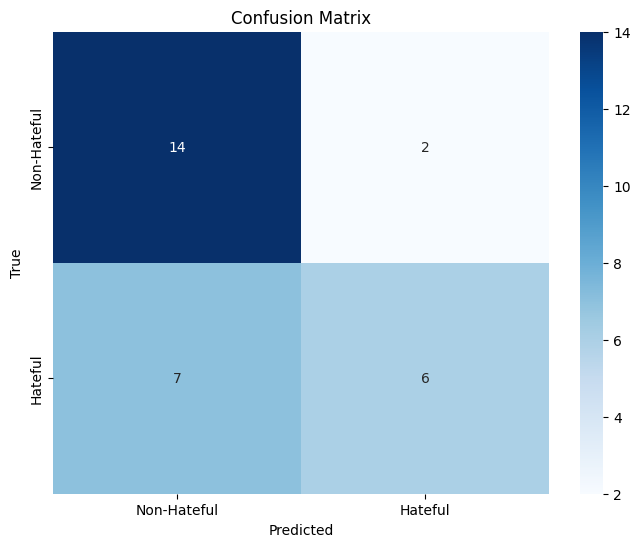

In [52]:
conf_matrix = confusion_matrix(y_test, rf_pred)

# 📌 Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hateful', 'Hateful'],
            yticklabels=['Non-Hateful', 'Hateful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Grid Search CV


🔍 Evaluating SVM with kernel = 'linear'
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.78      0.54      0.64        13

    accuracy                           0.72        29
   macro avg       0.74      0.71      0.71        29
weighted avg       0.73      0.72      0.71        29



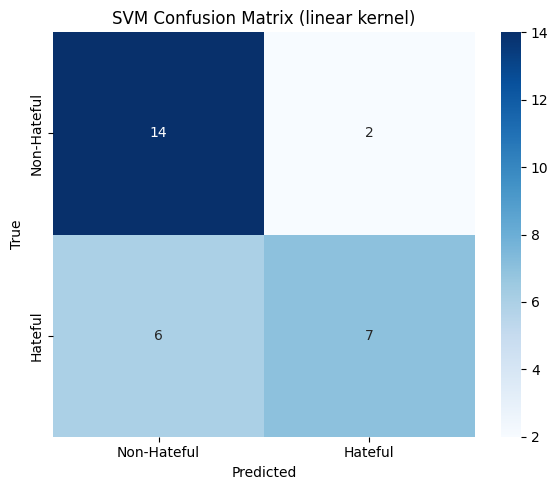


🔍 Evaluating SVM with kernel = 'rbf'
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.68      1.00      0.81        13

    accuracy                           0.79        29
   macro avg       0.84      0.81      0.79        29
weighted avg       0.86      0.79      0.79        29



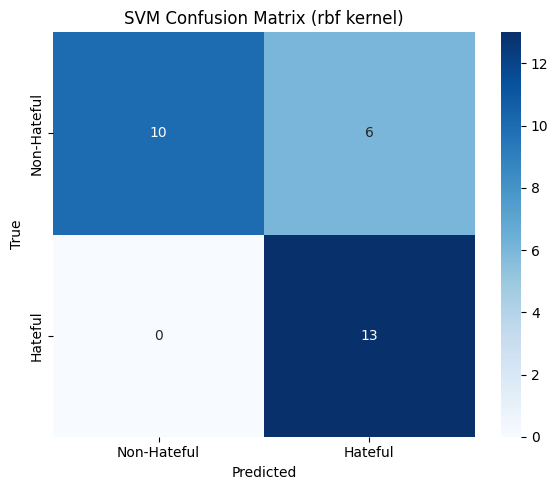


🔍 Evaluating SVM with kernel = 'poly'
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        16
           1       1.00      0.08      0.14        13

    accuracy                           0.59        29
   macro avg       0.79      0.54      0.44        29
weighted avg       0.76      0.59      0.47        29



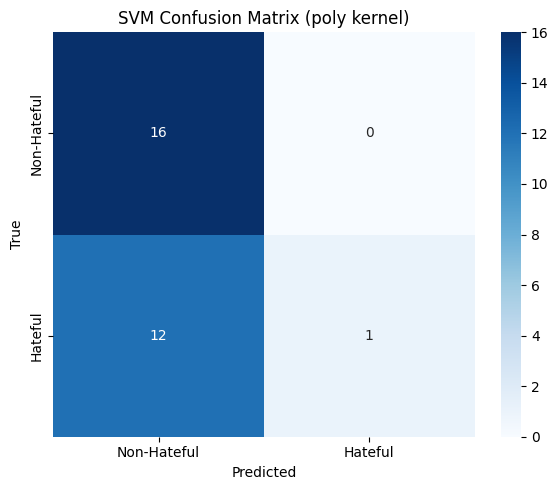


🔍 Evaluating SVM with kernel = 'sigmoid'
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.80      0.62      0.70        13

    accuracy                           0.76        29
   macro avg       0.77      0.75      0.75        29
weighted avg       0.77      0.76      0.75        29



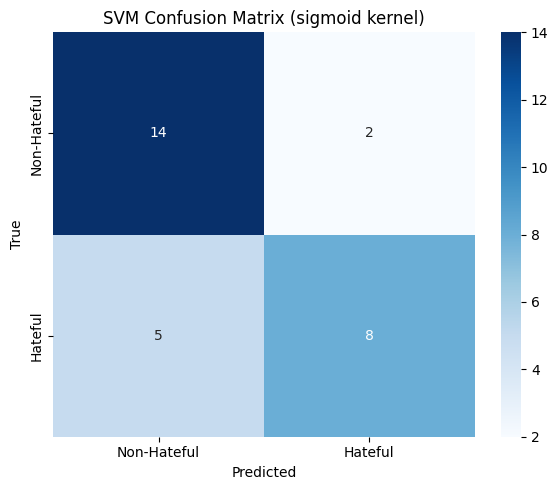

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Kernels to evaluate
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Store results
svm_reports = {}
conf_matrices = {}

for kernel in kernels:
    print(f"\n🔍 Evaluating SVM with kernel = '{kernel}'")

    # Set degree only for poly kernel
    if kernel == 'poly':
        model = SVC(kernel=kernel, degree=3, C=1, gamma='scale', class_weight='balanced')
    else:
        model = SVC(kernel=kernel, C=1, gamma='scale', class_weight='balanced')
    
    model.fit(X_train, y_train)
    y_pred_kernel = model.predict(X_test)
    
    # Store report and confusion matrix
    report = classification_report(y_test, y_pred_kernel, output_dict=True)
    svm_reports[kernel] = report
    conf_matrices[kernel] = confusion_matrix(y_test, y_pred_kernel)
    
    # Print classification report
    print(classification_report(y_test, y_pred_kernel))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[kernel], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Hateful', 'Hateful'],
                yticklabels=['Non-Hateful', 'Hateful'])
    plt.title(f"SVM Confusion Matrix ({kernel} kernel)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [55]:
# Step 3: Train a Logistic Regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [56]:
# Step 4: Predict on the test set
y_pred = model.predict(X_test)


In [57]:

# Step 5: Evaluate the model using confusion matrix and classification report
conf_matrix2 = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
# Print classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.78      0.54      0.64        13

    accuracy                           0.72        29
   macro avg       0.74      0.71      0.71        29
weighted avg       0.73      0.72      0.71        29



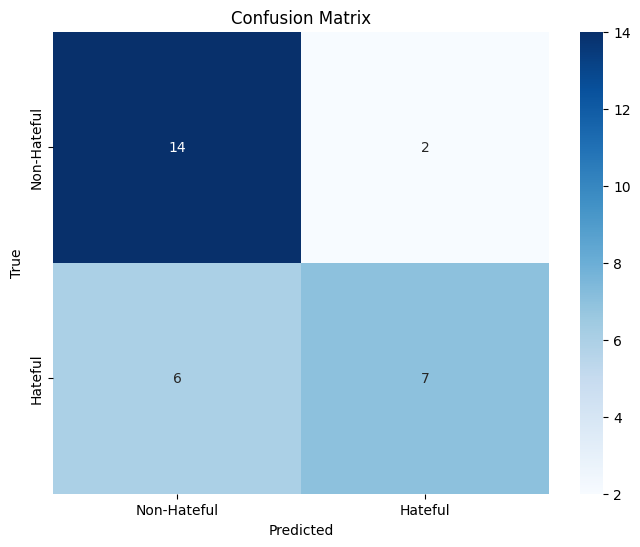

In [58]:
# Step 6: Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:

# List of hateful keywords
hateful_keywords = [
    "ವಾಂತಿ", "ಮನೆಹಾಳ", "ಮಗನದು", "ಕಿಕ್ ಕೊಡೋ", "ಮಗ", "ಮಗನೇ", "ಚಿಂಟು", "ಖಡ್ಡಿ", "ಅಸ್ತಿಪಂಜರ",
    "ಕಿಸ್ ಕೊಡ್ತಿನಿ", "ಕತ್ತರ್ಸ್ ಕೊಡ್ತಿನಿ", "ಬಾಯಿಗೆ ಬಂದಂಗೆ ಬೈದು", "ಗ್ಯಾಂಗ್‌ರೇಪ್", "ಮಂಗಾಟ", "ಸುಳ್",
    "ಕತ್ತಲ ಕಾಮುಕ", "ರಂಡಿ", "ಕಾಮುಕ", "ಚುಟಿಯಾ", "ಮಹಿಳೇಯರ ಗ್ಯಾರೇಜ್", "ದ್ರೋಹಿ", "ಕಿಸ್", "ಅಪಮಾನ", "ಜಾತಿ",
    "ದ್ವೇಷ", "ಭ್ರಷ್ಟಾಚಾರ", "ಇಲ್ಲ", "ಬೋ", "ಅನ್ಯಾಯ", "ರಾಜಕಾರಣಿ", "ಮೋಸ", "ರೇಪ್", "ಅಸ್ತಿಪಂಜರಾ", "ಮಧ್ಯ"
]

# Function to extract keywords
def extract_keywords(text):
    return [kw for kw in hateful_keywords if kw in text]

df['keywords'] = df['clean_text'].apply(extract_keywords)

# Keyword → Topic mapping
keyword_topic_map = {
    # Offensive Language / Abuse
    'ಕಾಮುಕ': 'Offensive Language', 'ಚುಟಿಯಾ': 'Offensive Language', 'ಮನೆಹಾಳ': 'Gender',
    'ಅಪಮಾನ': 'Insult', 'ಬೋ': 'Offensive Language', 'ಮಗನೇ': 'Offensive Language',
    'ಅಸ್ತಿಪಂಜರಾ': 'Offensive Language', 'ಮಧ್ಯ': 'Offensive Language', 'ವಾಂತಿ': 'Disgust',
    'ಮಗನದು': 'Offensive Language', 'ಮಗ': 'Offensive Language', 'ಬಾಯಿಗೆ ಬಂದಂಗೆ ಬೈದು': 'Abusive Language',
    'ಅಸ್ತಿಪಂಜರ': 'Body Shaming', 'ಖಡ್ಡಿ': 'Body Shaming', 'ಚಿಂಟು': 'Insult',
    'ಸುಳ್': 'Vulgarity', 'ಅಭಮಸ್ಸ್': 'Offensive Language', 'ಬೋ ಮ': 'Offensive Language',
    'ಕುಡದ್ರೆ': 'Offensive Language',

    # Gender / Misogyny
    'ಮಹಿಳೇಯರ ಗ್ಯಾರೇಜ್': 'Gender', 'ರಂಡಿ': 'Gender',
    'ಸಾವಿರ ಹುಡುಗರು UNCLE ಜೊತೆ ಮದುವೆ': 'Gender', 'ಕಟ್ಟಾರೆ... ನಗ್ ನಗ್ತಾನೆ ಸಮಾಧಿ': 'Gender',
    'ಹುಡಗಿ ವಾಂತಿ ಮಾಡಿದ್ರ': 'Gender', 'ಹುಡುಗ್ರು ಮಾತಲ್ಲೇ ಮನೆ ಕಟ್ಟಾರೆ': 'Gender', 'ಅತ್ತಿಗೆ': 'Gender',

    # Sexual / Vulgar / Double Meaning
    'ಕಿಸ್': 'Sexual', 'ಕಿಸ್ ಕೊಡ್ತಿನಿ': 'Sexual', 'ಗ್ಯಾಂಗ್‌ರೇಪ್': 'Sexual Violence',
    'ರೇಪ್': 'Sexual Violence', 'ಕತ್ತರ್ಸ್ ಕೊಡ್ತಿನಿ': 'Threat',
    'ರೂಮ್ ಬಾ ರಂಡಿ': 'Sexual', 'ಮುದ್ದಾಡೋ': 'Sexual', 'ಬ್ಯೂಟಿ ಪಾರ್ಲರ್': 'Sexual Implication',
    'ಅಷ್ಟೆ ನನಗೆ ನಿನ್ನ ಸಾಮಾನ್ ಬೇಕು': 'Sexual',

    # Hate Speech / Caste / Religion
    'ಜಾತಿ': 'Caste', 'ದ್ವೇಷ': 'Hate Speech', 'ಧರ್ಮ': 'Religion',
    'ಹಣೆಗೆ ಬಂದೂಕು ಇಟ್ಟಾಗ': 'Caste', 'ದೇವ್ರೇ': 'Religious Reference',
    'ಸಾಬರು ಬುರ್ವಾ CET ಬರೆಯಬಹುದು': 'Caste',

    # Betrayal / Fraud / Negativity
    'ದ್ರೋಹಿ': 'Betrayal', 'ಮೋಸ': 'Fraud', 'ಇಲ್ಲ': 'Negativity',

    # Insult / Disrespect / Mockery
    'ಅನ್ಯಾಯ': 'Injustice', 'ತೊಂಡೆ': 'Disrespect', 'ಹೇಳು ಚಡ್ಡಿಯ ಮೇಲೆ ಬರೆಸಿರುವೆ': 'Insult',
    'ಹೆಂಡತಿ; ಸಿಟ್ಟಿನಿಂದ': 'Insult', 'ಹೆಂಡತಿ ಕೇಳಿದಾಗ ಗಾಬರಿ': 'Mockery',

    # Violence / Threat
    'ಕಿಕ್ ಕೊಡೋ': 'Violence', 'ಚಾಕುವಿನಿಂದ ಇರಿದು': 'Violence',
    'ಬದುಕ್ತಿದೊ': 'Violence', 'ಇಡೀ ಕುಟುಂಬ ಹಾಳು': 'Violence',

    # Corruption / Politics / Sarcasm
    'ರಾಜಕಾರಣಿ': 'Politics', 'ಭ್ರಷ್ಟಾಚಾರ': 'Corruption', 'ಮೋಡಿ JUDGE': 'Politics',
    'ಅಪಾಧ್ಯಕ್ಷರೇ 2000 ರೂಪಾಯಿ ನೋಟು': 'Politics', 'MSD ಎಣ್ಣೆ ಕಿಕ್ ಕೊಡೋ': 'Sarcasm',
    'ಎಡವಿದ್ರೆ ಪೆಟ್ಟಾಯ್ತಾ': 'Sarcasm', 'ಬೆಂಕಿ ಕೆಂಡ ಇದೆ ಮಗನೇ': 'Sarcasm'
}


# Map topics
def map_topics(keywords):
    return list({keyword_topic_map.get(kw, 'Other') for kw in keywords})

df['topics'] = df['keywords'].apply(map_topics)

# Filter only hateful memes
hateful_df = df[df['hate_pred'] == 'Hateful']


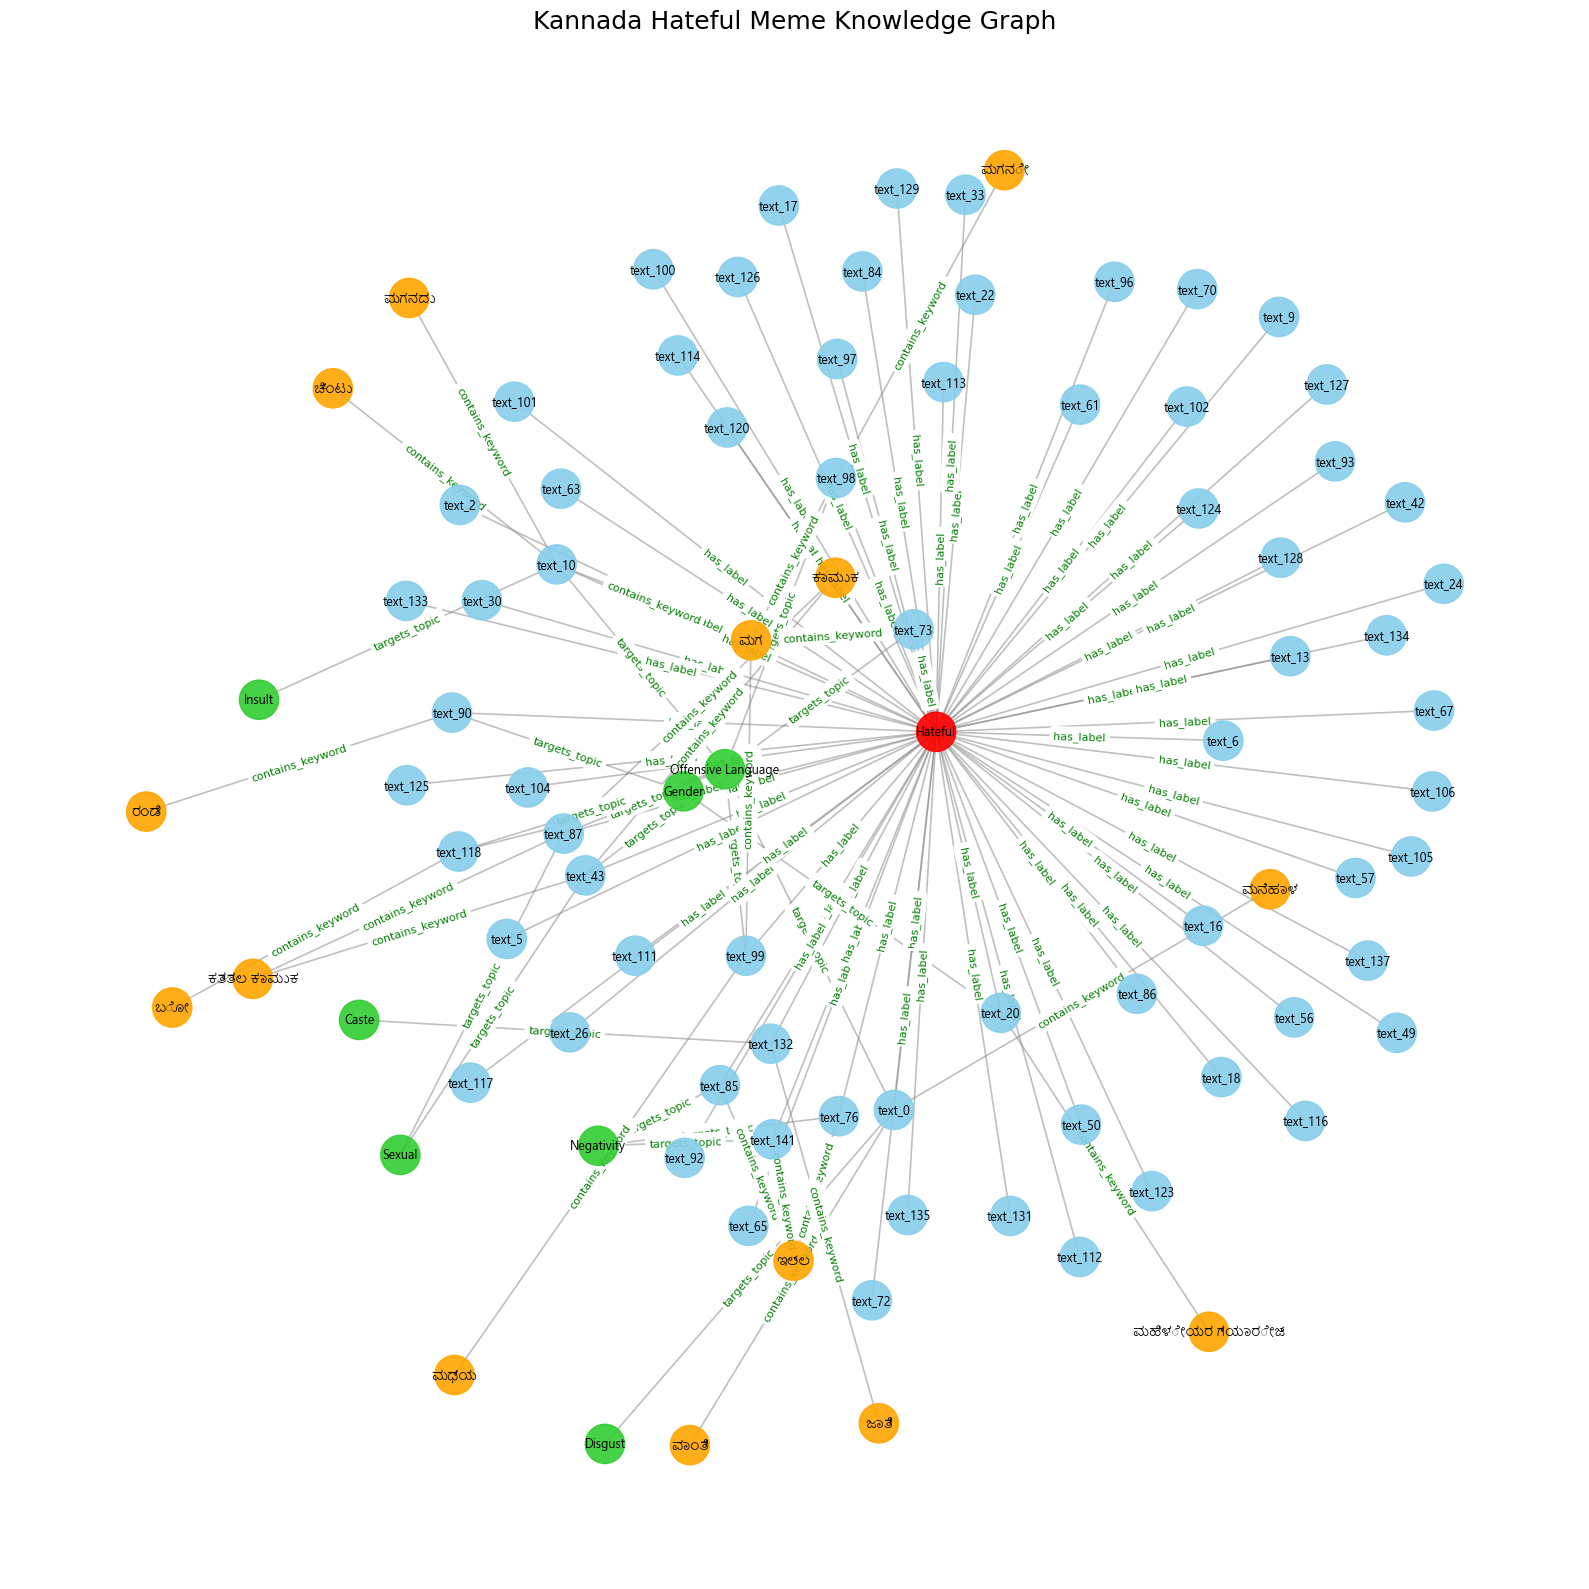

In [60]:

import networkx as nx
def extract_keywords(text):
    return [kw for kw in hateful_keywords if kw in text]

def map_topics(keywords):
    return list({keyword_topic_map.get(kw, 'Other') for kw in keywords})

df['keywords'] = df['clean_text'].apply(extract_keywords)
df['topics'] = df['keywords'].apply(map_topics)

# === STEP 3: Build Graph for Hateful Memes Only ===

hateful_df = df[df['hate_pred'] == 'Hateful']
G = nx.Graph()

for idx, row in hateful_df.iterrows():
    text_node = f"text_{idx}"
    G.add_node(text_node, label='Text', type='text', content=row['clean_text'])

    for kw in row['keywords']:
        G.add_node(kw, label='Keyword', type='keyword')
        G.add_edge(text_node, kw, relation='contains_keyword')

    for topic in row['topics']:
        G.add_node(topic, label='Topic', type='topic')
        G.add_edge(text_node, topic, relation='targets_topic')

    label = row['hate_pred']
    G.add_node(label, label='Label', type='label')
    G.add_edge(text_node, label, relation='has_label')

# Save graph
nx.write_gml(G, "hateful_meme_graph.gml")

# === STEP 4: Visualize Graph ===

# Reload (optional)
G = nx.read_gml("hateful_meme_graph.gml")

# Colors by node type
color_map = {
    'text': 'skyblue',
    'keyword': 'orange',
    'topic': 'limegreen',
    'label': 'red'
}
node_colors = [color_map.get(G.nodes[n]['type'], 'gray') for n in G.nodes()]

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, k=0.6)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.9, node_size=800)
nx.draw_networkx_edges(G, pos, width=1.2, edge_color='gray', alpha=0.5)

nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_family='Nirmala UI', font_size=9)

# Edge relation labels
edge_labels = {(u, v): G.edges[u, v]['relation'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='green')

plt.title("Kannada Hateful Meme Knowledge Graph", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

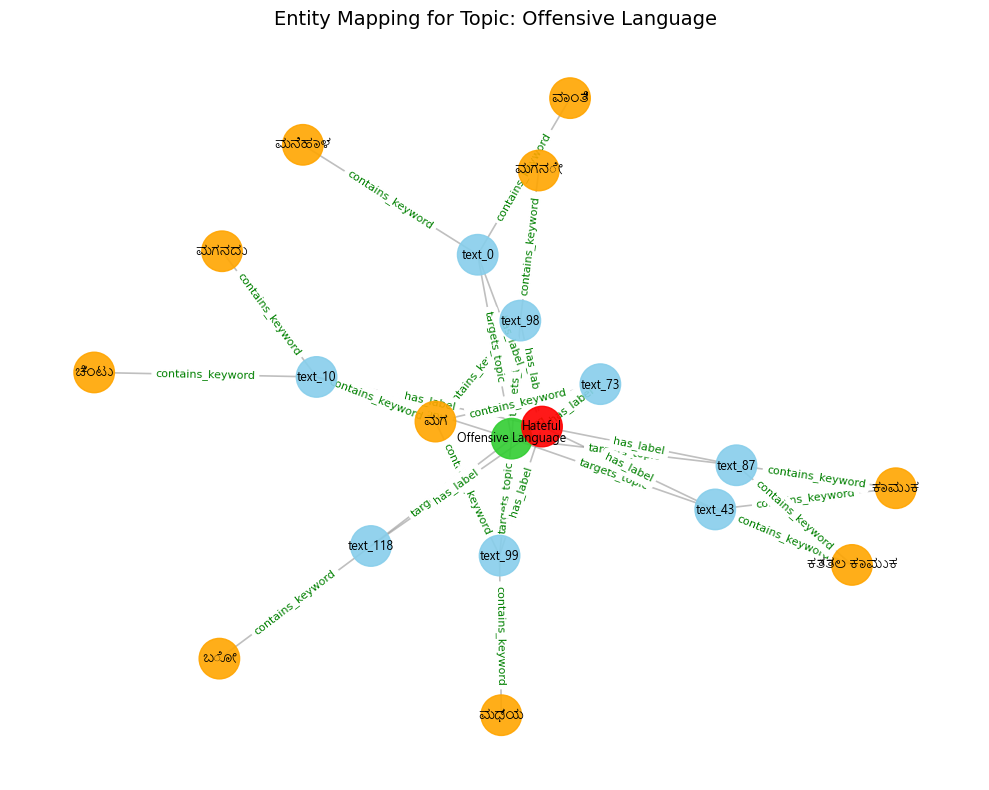

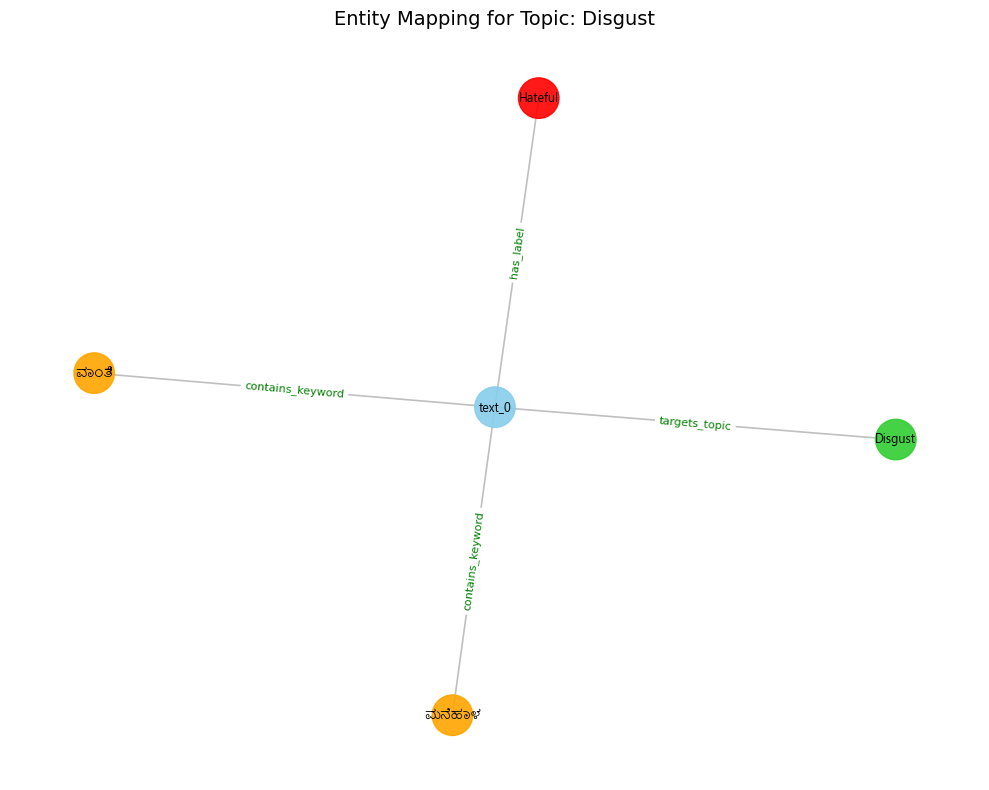

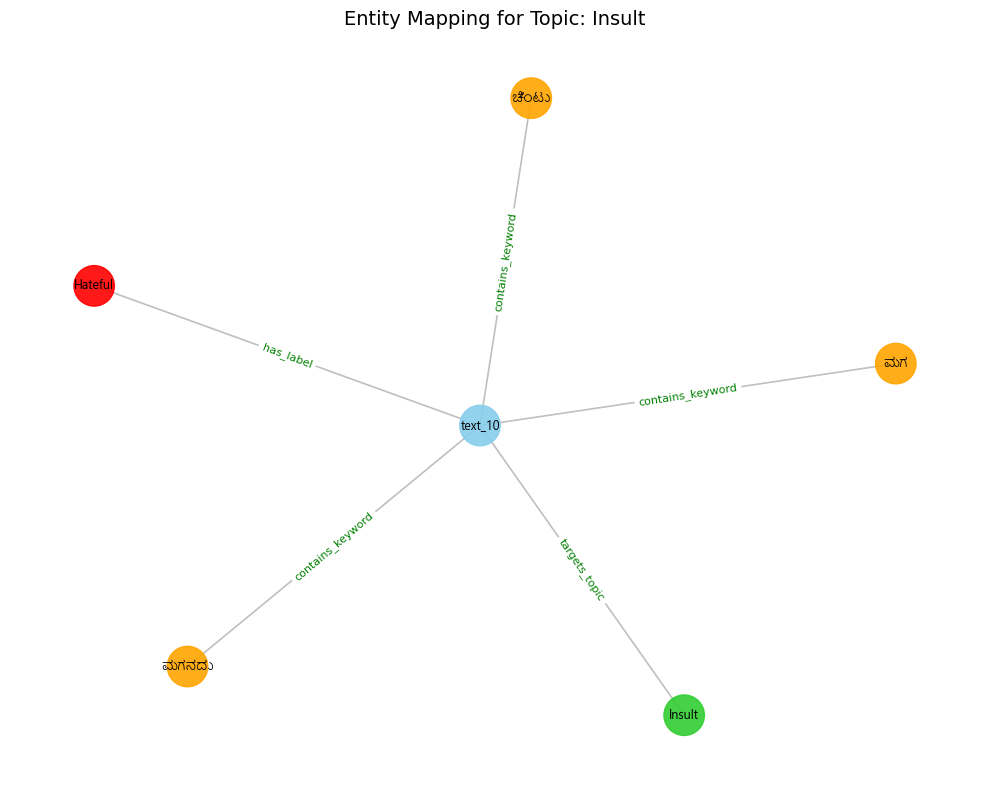

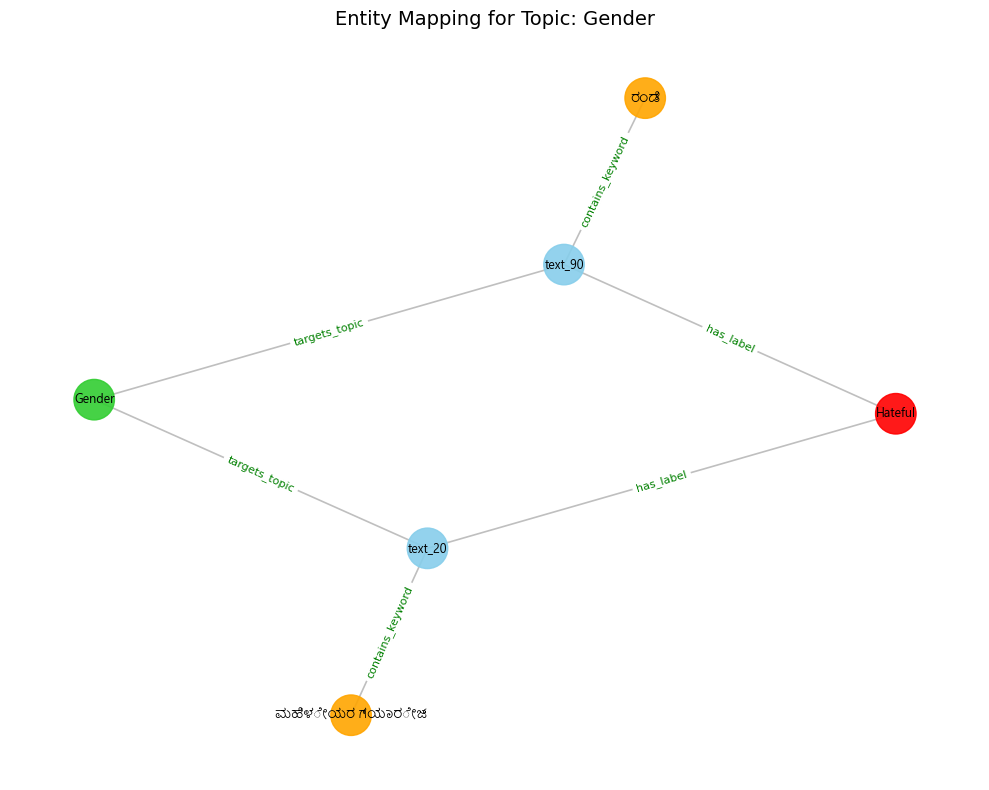

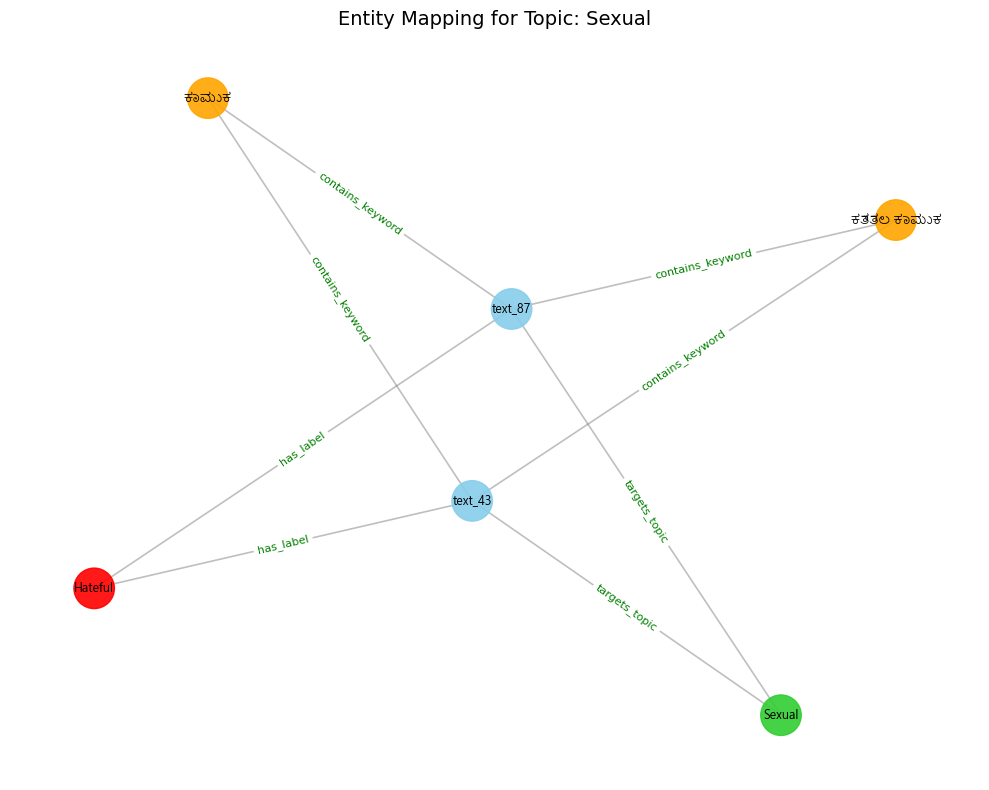

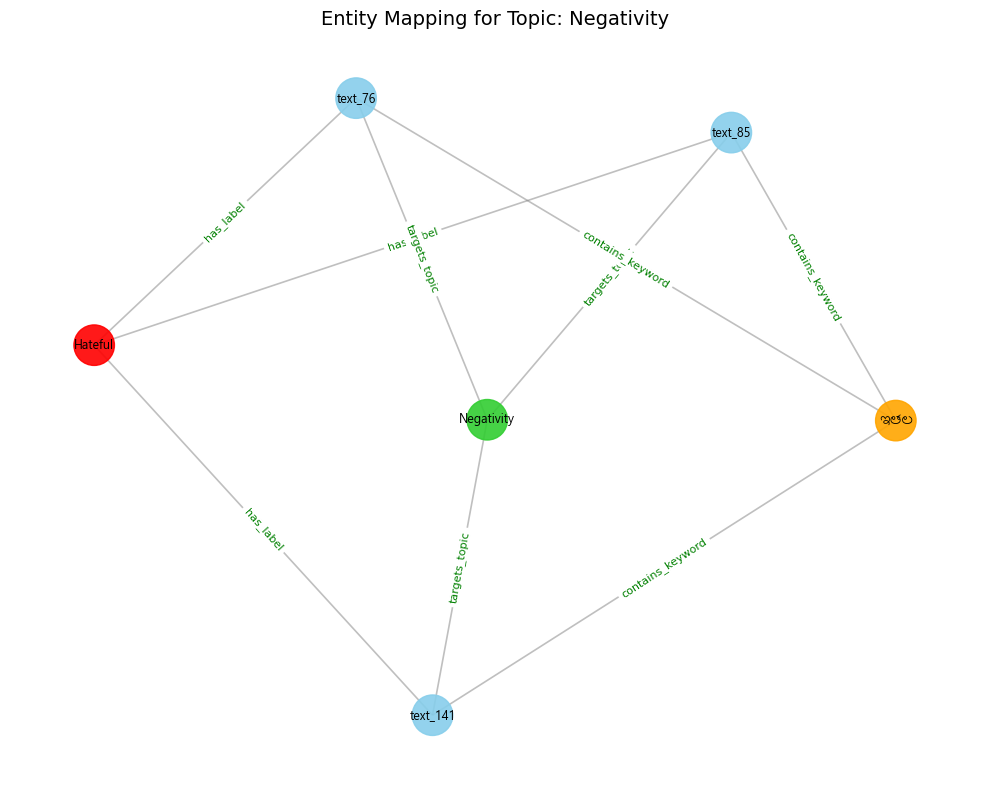

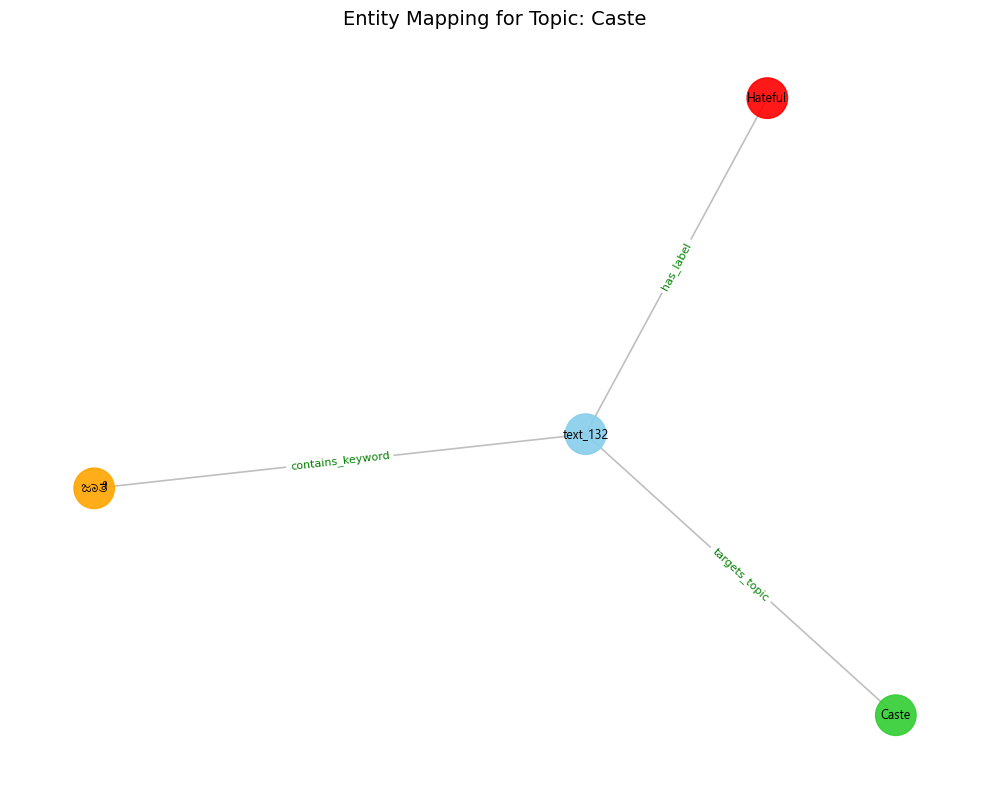

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

# Load full graph
G = nx.read_gml("hateful_meme_graph.gml")

# Get all topic nodes
topic_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type") == "topic"]

for topic in topic_nodes:
    # 1-hop: Find texts connected to topic
    text_neighbors = [nbr for nbr in G.neighbors(topic) if G.nodes[nbr]['type'] == 'text']

    # 2-hop: Find keywords and labels connected to those texts
    keyword_neighbors = []
    label_neighbors = []
    for text in text_neighbors:
        keyword_neighbors += [nbr for nbr in G.neighbors(text) if G.nodes[nbr]['type'] == 'keyword']
        label_neighbors += [nbr for nbr in G.neighbors(text) if G.nodes[nbr]['type'] == 'label']

    keyword_neighbors = list(set(keyword_neighbors))
    label_neighbors = list(set(label_neighbors))

    # All nodes in this subgraph
    nodes_to_include = [topic] + text_neighbors + keyword_neighbors + label_neighbors
    subG = G.subgraph(nodes_to_include)

    # Visualize
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subG, seed=42)

    # Color coding
    node_colors = [
        'limegreen' if G.nodes[n]['type'] == 'topic' else
        'skyblue' if G.nodes[n]['type'] == 'text' else
        'orange' if G.nodes[n]['type'] == 'keyword' else
        'red' if G.nodes[n]['type'] == 'label' else 'gray'
        for n in subG.nodes()
    ]

    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=850, alpha=0.9)
    nx.draw_networkx_edges(subG, pos, width=1.2, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(subG, pos, labels={n: n for n in subG.nodes()}, font_family='Nirmala UI', font_size=9)

    edge_labels = {(u, v): G.edges[u, v]['relation'] for u, v in subG.edges()}
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=8, font_color='green')

    plt.title(f"Entity Mapping for Topic: {topic}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()  # Display instead of saving


In [62]:
print(G.nodes['text_132']['content'])

# Or get all texts in a DataFrame
import pandas as pd

df_text_lookup = pd.DataFrame([
    (n, d['content']) for n, d in G.nodes(data=True)
    if d.get('label') == 'text'
], columns=['Node', 'Text'])


ಹಣೆಗೆ ಬಂದೂಕು ಇಟ್ಟಾಗ ಕೇಳಿದ್ದು ನಿನ್ ಯಾವ್ ಜಾತಿ ಅಂತ ಅಲ್ಲಾ ಯಾವ್ ಧರ್ಮ ಅಂತ     ಧರ್ಮ ತಪ್ಪಾಗಿ ಹೇಳಿದಿದ್ರೆ ಬದುಕ್ತಿದೊ ಏನೋ ಈ
